In [1]:
# importing the required modules

import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq, fftshift

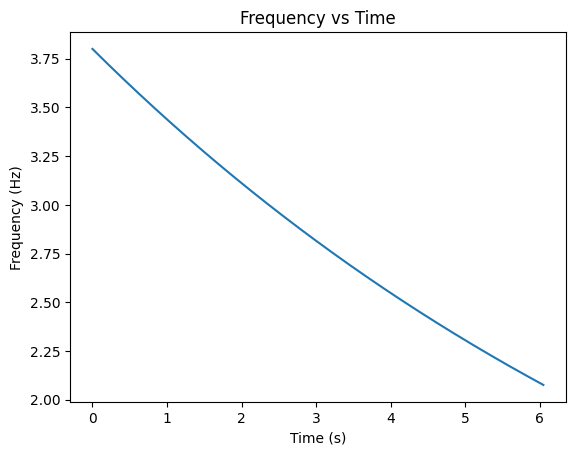

In [6]:
# info about the data
f_i = 3.8 # initial frequency
decay_rate = 0.1 # decay rate of frequency
freq_sampling =  114795 / 5.78562

N_samples = 120000 # number of samples
Total_time = N_samples / freq_sampling # total time

t = np.linspace(0, Total_time, N_samples, endpoint=False) # time array
f = f_i * np.exp(-decay_rate * t) # frequency array

# plot the frequency vs time
plt.plot(t, f)
plt.title('Frequency vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

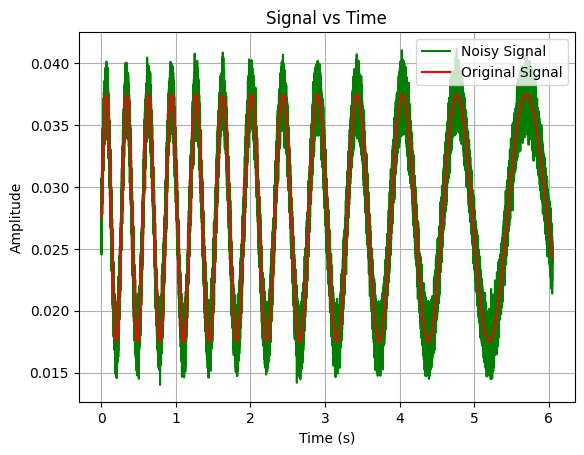

In [29]:
# creating a sin wave with the frequency array
y = 0.01*np.sin(2 * np.pi * f * t) + 0.0275

# adding some noise to the signal
y_noise = y + 0.001 * np.random.normal(size=t.size)

# plot the signal
plt.plot(t, y_noise, 'g',label='Noisy Signal')
plt.plot(t, y, 'r',label='Original Signal')
plt.title('Signal vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()
plt.show()


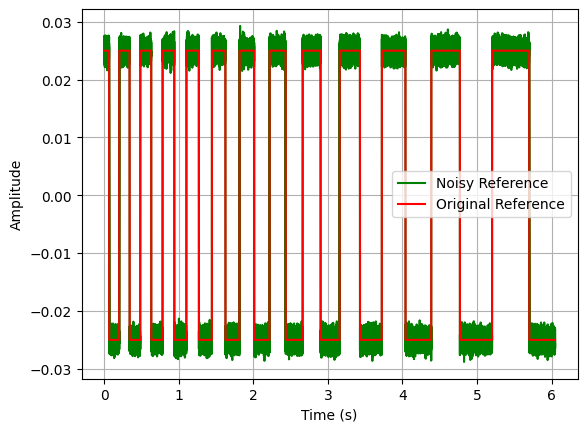

In [30]:
# creeating a squarae wave with the frequency array and a phase shift of 90 degrees
y_square = 0.05*np.sin(2 * np.pi * f * t + np.pi/2)

# converting the signal to a square wave
y_square = 0.025* np.sign(y_square)

# adding some noise to the signal
y_square_noise = y_square + 0.0009 * np.random.normal(size=t.size)

# plot the signal
plt.plot(t, y_square_noise, 'g',label='Noisy Reference')
plt.plot(t, y_square, 'r',label='Original Reference')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()
plt.show()

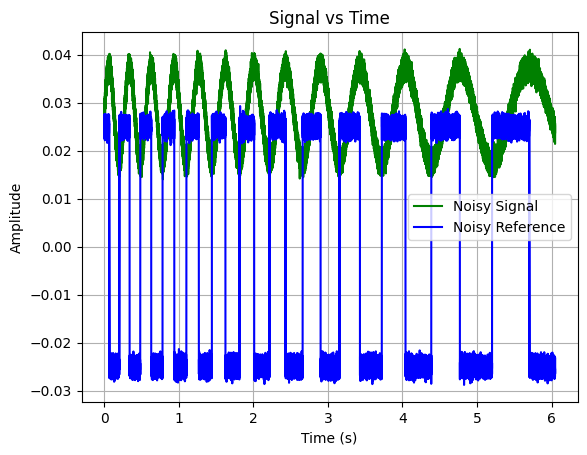

In [31]:
# plotting the current signal and the reference signal
plt.plot(t, y_noise, 'g',label='Noisy Signal')
# plt.plot(t, y, 'r',label='Original Signal')
plt.plot(t, y_square_noise, 'b',label='Noisy Reference')
# plt.plot(t, y_square, 'y',label='Original Reference')
plt.title('Signal vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()
plt.show()

In [32]:
ref_data = np.array([t, y_square_noise])
sig_data = np.array([t, y_noise])

print(ref_data.shape)
print(sig_data.shape)

N_sample = 120000 # number of samples

(2, 120000)
(2, 120000)


In [33]:
# finding the first rise index and further indices where reference signal gradiant changes

ref_sig_max = np.max(ref_data[1])
ref_sig_min = np.min(ref_data[1])

# centralizing the reference signal
ref_data[1] = ref_data[1] - ((ref_sig_max + ref_sig_min)/2)

first_rise_idx = 0
for i in range(1, N_sample):
    if ref_data[1][i] > 0 and ref_data[1][i-1] < 0:
        first_rise_idx = i
        break

ref_cross_idx = [first_rise_idx]
for i in range(first_rise_idx + 1, N_sample):
    if ref_data[1][i]*ref_data[1][i-1] < 0:
        ref_cross_idx.append(i)

triggered_sig = sig_data[1][first_rise_idx:]
triggered_ref = ref_data[1][first_rise_idx:]
triggered_time = sig_data[0][first_rise_idx:] - sig_data[0][first_rise_idx] # time starts from zero

ref_cross_idx = np.array(ref_cross_idx)
ref_cross_idx = ref_cross_idx - first_rise_idx # resetting the indices to start from zero

print(triggered_sig.shape)
print(triggered_ref.shape)
print(triggered_time.shape)
print(triggered_time)
print()
print(ref_cross_idx.shape)
print(ref_cross_idx)


(116004,)
(116004,)
(116004,)
[0.00000000e+00 5.03995819e-05 1.00799164e-04 ... 5.84640190e+00
 5.84645230e+00 5.84650269e+00]

(24,)
[     0   2757   5594   8517  11532  14646  17866  21200  24660  28255
  32000  35908  39998  44290  48809  53585  58656  64067  69878  76168
  83043  90652  99222 109116]


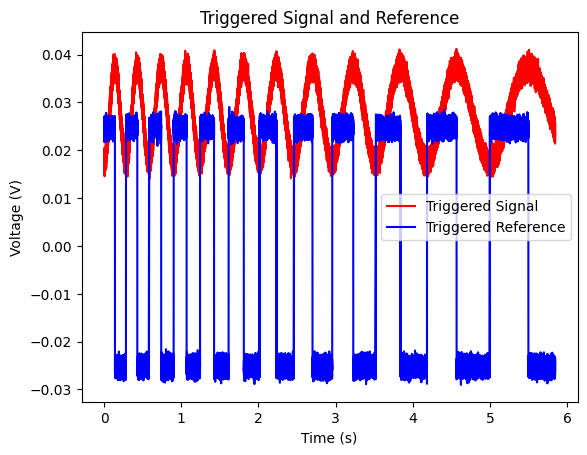

In [34]:
# plotting the triggered signals
plt.plot(triggered_time, triggered_sig, 'r', label='Triggered Signal')
plt.plot(triggered_time, triggered_ref, 'b', label='Triggered Reference')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('Triggered Signal and Reference')
plt.legend()
plt.show()

#### Square wave to sine wave.

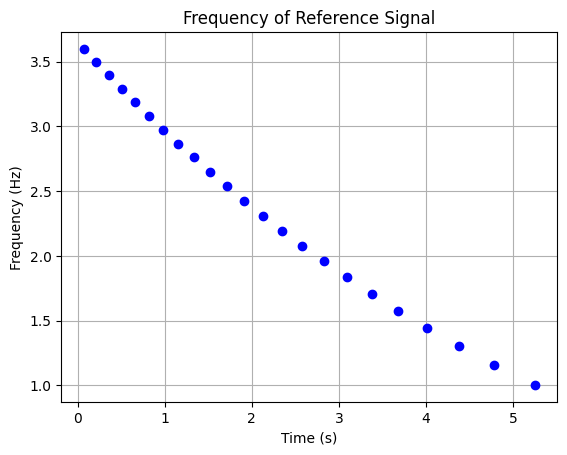

In [35]:
# finding the changing frequency of reference signal based on the zero crossings
N_cross = ref_cross_idx.shape[0]
time_period = np.zeros(N_cross - 1)
frequency = np.zeros(N_cross - 1)
time_of_frequency = np.zeros(N_cross - 1)

for i in range(N_cross - 1):
    time_period[i] = 2 * (triggered_time[ref_cross_idx[i+1]] - triggered_time[ref_cross_idx[i]])
    frequency[i] = 1/time_period[i]
    time_of_frequency[i] = (triggered_time[ref_cross_idx[i+1]] + triggered_time[ref_cross_idx[i]])/2
    
# plotting the frequency
plt.plot(time_of_frequency, frequency, 'bo')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Frequency of Reference Signal')
plt.grid()
plt.show()

sus!


Initial Frequency:  3.775881872659436
Decay Rate:  0.24099513786005533


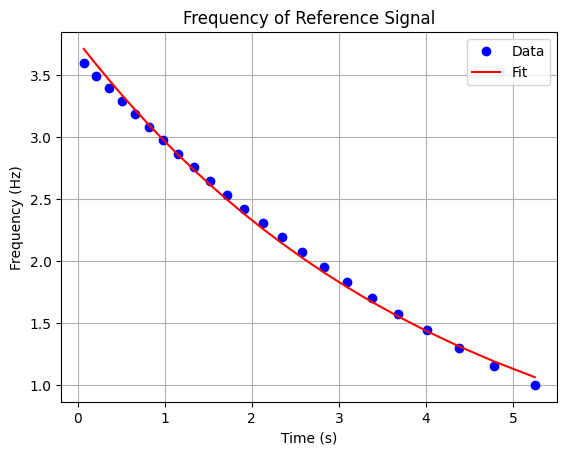

In [37]:
# fitting the frequency data with an exponential decay
fit = np.polyfit(time_of_frequency, np.log(frequency), 1)
decay_rate_obs = -fit[0]
f_i_obs = np.exp(fit[1])

print('Initial Frequency: ', f_i_obs)
print('Decay Rate: ', decay_rate_obs)

# plotting the frequency vs time
plt.plot(time_of_frequency, frequency, 'bo', label='Data')
plt.plot(time_of_frequency, f_i_obs * np.exp(-decay_rate_obs * time_of_frequency), 'r', label='Fit')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Frequency of Reference Signal')
plt.legend()
plt.grid()
plt.show()

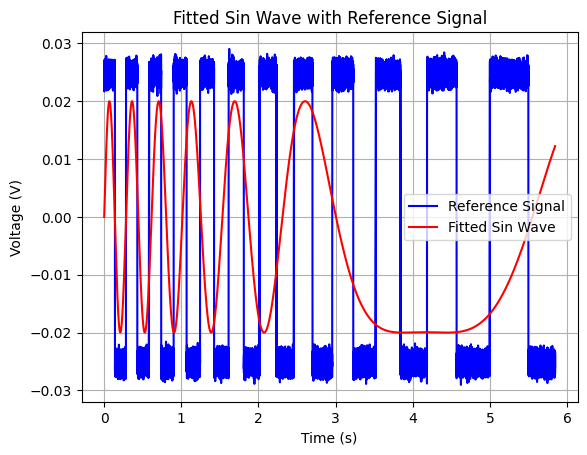

In [38]:
# using the fit_fn to find the frequency at each time step
fitted_frequency = f_i_obs * np.exp(-decay_rate_obs * triggered_time)

# constructing a sin wave with the fitted frequency and the time and an amplitude of 0.025 (later 2V)
fitted_sin_ref = 0.02 * np.sin(2 * np.pi * fitted_frequency * triggered_time)

# plotting the fitted sin wave with reference signal
plt.plot(triggered_time, triggered_ref, 'b', label='Reference Signal')
plt.plot(triggered_time, fitted_sin_ref, 'r', label='Fitted Sin Wave')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('Fitted Sin Wave with Reference Signal')
plt.legend()
plt.grid()
plt.show()


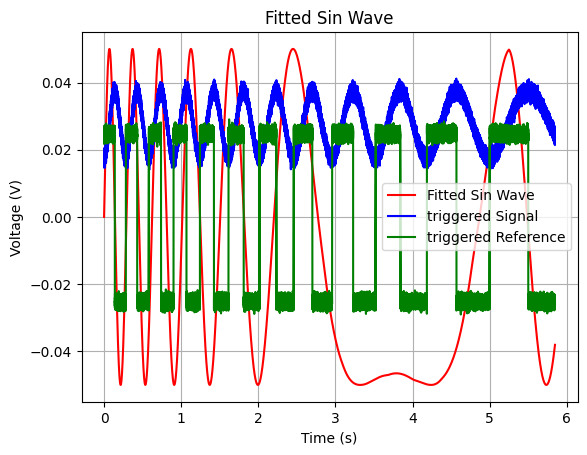

In [39]:
# alternate option to 'fit' the frequency is to make a linear intrapolation of the frequency data
# this is done by using the np.interp function
fitted_frequency = np.interp(triggered_time, time_of_frequency, frequency)

# plotting the new sine wave
sin_wave = 0.05 * np.sin(2 * np.pi * fitted_frequency * triggered_time)
plt.plot(triggered_time, sin_wave, 'r', label='Fitted Sin Wave')
plt.plot(triggered_time, triggered_sig, 'b', label='triggered Signal')
plt.plot(triggered_time, triggered_ref, 'g', label='triggered Reference')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('Fitted Sin Wave')
plt.legend()
plt.grid()
plt.show()

#### Eureka! 
I have found a solution to this problem. 
It seems that the problem is caused by the unknown time values used by the original signal and reference. (even under our assumption of exponential decay, without the original time values, we cannot reconstruct the original reference signal)

#### solution
We can try solving the problem by changing our assumption to the form:
$$
f_t = f_0 \cdot e^{-\lambda (t_0 + t)} + C
$$
where $t_0$ and $f_0$ are the unknown starting time and frequency of the original signal. (C is the unknown constant)

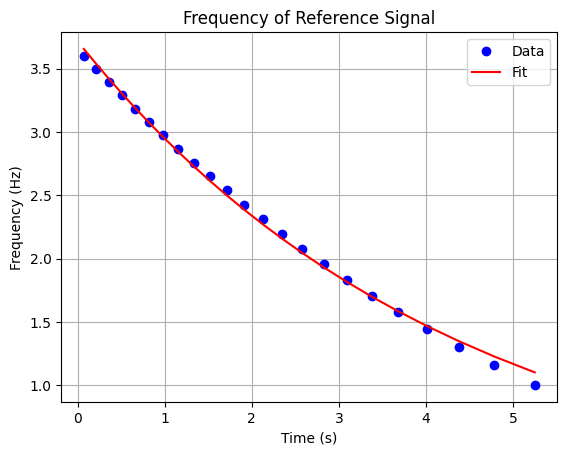

Initial Frequency: 3.7160334342267802
Decay Rate: 0.23152642503754087


In [51]:
# fitting the frequency data with an exponential decay of form A * exp(-B * (C + t))

def fit_function(t, f0, lambda_val):
    return f0 * np.exp(-lambda_val * (t))

# fitting the frequency data
from scipy.optimize import curve_fit
popt, pcov = curve_fit(fit_function, time_of_frequency, frequency, p0=[f_i, decay_rate])

# plotting the frequency vs time
plt.plot(time_of_frequency, frequency, 'bo', label='Data')
plt.plot(time_of_frequency, fit_function(time_of_frequency, *popt), 'r', label='Fit')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Frequency of Reference Signal')
plt.legend()
plt.grid()
plt.show()

print(f'Initial Frequency: {popt[0]}')
print(f'Decay Rate: {popt[1]}')
# print(f'Constant: {popt[3]}')
# print(f'Constant: {popt[2]}')

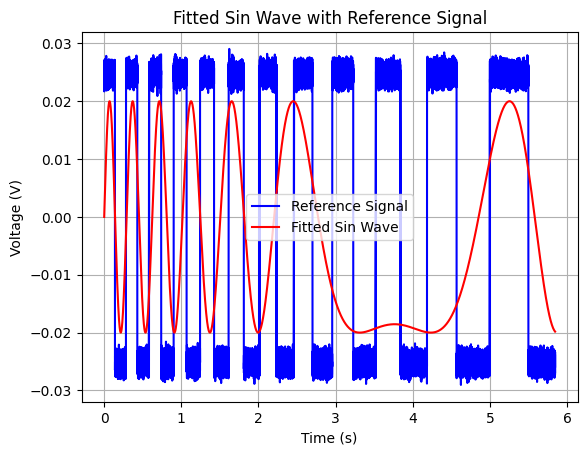

In [42]:
# reconstructing a sin wave with the fitted frequency and the time and an amplitude of 0.025 (later 2V)
fitted_sin_ref = 0.02 * np.sin(2 * np.pi * fit_function(triggered_time, *popt) * triggered_time)

# plotting the fitted sin wave with reference signal
plt.plot(triggered_time, triggered_ref, 'b', label='Reference Signal')
plt.plot(triggered_time, fitted_sin_ref, 'r', label='Fitted Sin Wave')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('Fitted Sin Wave with Reference Signal')  
plt.legend()
plt.grid()
plt.show()

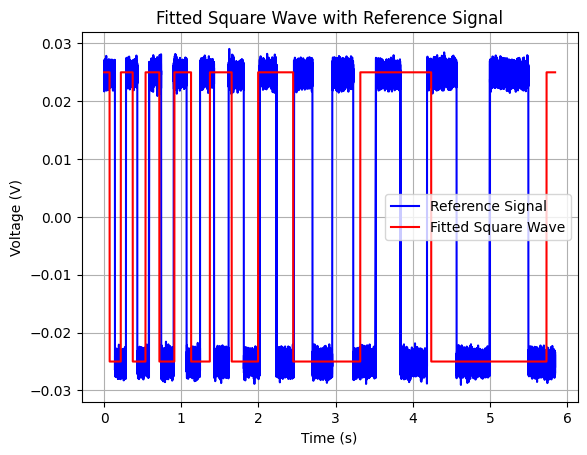

In [43]:
# reconstructing a square wave with the fitted frequency and the time
fitted_square_ref = 0.025 * np.sin(2 * np.pi * fitted_frequency * triggered_time + np.pi/2)
fitted_square_ref = 0.025 * np.sign(fitted_square_ref)

